In [21]:
import nltk 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
!pip install contractions
import contractions 
import string

In [22]:
pd.set_option('display.max_colwidth',100)
# Load training set 
raw_ = pd.read_csv('text-data/train.csv')
raw_.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAf...,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [23]:
raw_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [24]:
# split data into training and test 
X_train, X_test, y_train, y_test = train_test_split(raw_[['text']],raw_['target'],random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(20)

(5709, 1) (1904, 1)


,text
5151,@dicehateme @PuppyShogun This makes sense. Paper beats rock paper comes from wood so wood should...
6351,'@CatoInstitute: The causes of federal failure are deeply structural and they will not be easily...
3443,Well as I was chaning an iPad screen it fucking exploded and glass went all over the place. Look...
7164,the war on drugs has turned the U.S. into a WAR zone.
7037,Obama Declares Disaster for Typhoon-Devastated Saipan
5159,According to prophecy and also CNN a Mac tablet will completely obliterate the need for other ga...
1010,Has body bagged ** RT @d_lac: Drake is body bagging meek
5070,@ConnorFranta #AskConnor if you were a natural disaster what would you be?
2069,@soapscoop i need you to confirm that ross is dead cause i dont trust anyone else yh
931,@libraryeliza he did get a @taylorswift13 'bump' of approval which is probably why he's blown up...


In [25]:
# Exploring what the unique keywords and locations are 
non_null_kw = raw_.keyword.notnull()
non_null_loc = raw_.location.notnull()
raw_['keyword'][non_null_kw].unique()[:30]

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags'], dtype=object)

In [26]:
raw_['location'][non_null_loc].unique()[:30]

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil',
       'hollywoodland ', 'Edmonton, Alberta - Treaty 6',
       'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA',
       'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN',
       'Santa Clara, CA'], dtype=object)

#### Feature creation and evaluation 
Its worthwhile thinking about what kind of features could be useful in better predicting disasters. 

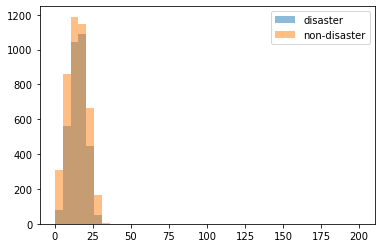

In [40]:
# Length of text 
raw_['doc_len'] = raw_['text'].apply(lambda x: len(x.split())) 
bins = np.linspace(0, 200, 40)
raw_['caps_count'] = raw_['text'].apply()
plt.hist(raw_[raw_['target']==1]['doc_len'], bins, alpha=0.5, label='disaster')
plt.hist(raw_[raw_['target']==0]['doc_len'], bins, alpha=0.5, label='non-disaster')
plt.legend(loc='upper right')
plt.show()

In [27]:
from nltk.tokenize import punkt 
from nltk import word_tokenize 
from nltk.corpus import stopwords 

# create a data cleaning function that tokenizes, 
# removes english stopwords and punctuations and returns tokenized text in lowercase 

eng_stop = stopwords.words('english') # english stopwords
wn = nltk.WordNetLemmatizer() # Instantiate word lemmatizer

def clean_text_lm(text):
    '''Removes punctuations and stopwords and returns lowercase tokenized text for input text and pattern'''
    # expand contracted sentences
    doc = contractions.fix(text) 
    
    # match regex pattern and replace with empty string
    doc_nousr = re.sub(r'@[^\s]+',r'',doc)
    doc_nourl = re.sub(r'(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+',r'',doc_nousr)
    doc_nospchar = re.sub(r'^a-zA-Z\s\W+',r'',doc_nourl,re.I | re.A) 
    
    # remove punctuations from previous out
    doc_nopunct = ''.join([char for char in doc_nospchar if char not in string.punctuation])
    
    # convert text to lower case and strip white space if any
    doc_lower_nospc = doc_nopunct.lower().strip() 
    
    # lemmatize and store in list format
    lem_text = [wn.lemmatize(word) for word in re.split('\W+',doc_lower_nospc)] 
    
     # join list into string with no stopwords
    no_stop_docs = ' '.join([word for word in lem_text if word not in eng_stop])
    
    return no_stop_docs
    
    

In [28]:
# Vectorize the function to apply accross dataframe
cleaner = np.vectorize(clean_text_lm)
# store values in separate column in df
X_train['cleaned_text'] = cleaner(X_train[['text']])
X_train.head(10)


,text,cleaned_text
5151,@dicehateme @PuppyShogun This makes sense. Paper beats rock paper comes from wood so wood should...,make sense paper beat rock paper come wood wood able support obliterate rock
6351,'@CatoInstitute: The causes of federal failure are deeply structural and they will not be easily...,cause federal failure deeply structural easily solved
3443,Well as I was chaning an iPad screen it fucking exploded and glass went all over the place. Look...,well wa chaning ipad screen fucking exploded glass went place look like job going need new one
7164,the war on drugs has turned the U.S. into a WAR zone.,war drug ha turned war zone
7037,Obama Declares Disaster for Typhoon-Devastated Saipan,obama declares disaster typhoondevastated saipan
5159,According to prophecy and also CNN a Mac tablet will completely obliterate the need for other ga...,according prophecy also cnn mac tablet completely obliterate need gadget combining û
1010,Has body bagged ** RT @d_lac: Drake is body bagging meek,ha body bagged rt drake body bagging meek
5070,@ConnorFranta #AskConnor if you were a natural disaster what would you be?,askconnor natural disaster would
2069,@soapscoop i need you to confirm that ross is dead cause i dont trust anyone else yh,need confirm ross dead trust anyone else yh
931,@libraryeliza he did get a @taylorswift13 'bump' of approval which is probably why he's blown up...,get bump approval probably blown musicadvisory


The cleaned text is now devoid of any special characters or stopwords, however its still not ready to be vectorized. The first action required is to tokenize the words, ie, converting the sentence into a list of words, and then, there can be many words that have a similar meaning such search, searching, searched, etc. I used a lemmatizer (WordNetLemmatizer) to correlate words with similar meaning and keeps the root words. 

In [29]:
# transform test set to vectorized format
X_test['cleaned_text'] = cleaner(X_test[['text']])
X_test.head()

,text,cleaned_text
2644,So you have a new weapon that can cause un-imaginable destruction.,new weapon unimaginable destruction
2227,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons...,famp thing gishwhes got soaked deluge going pad tampon thx
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool St...,dt rt ûïthe col police catch pickpocket liverpool
132,Aftershock back to school kick off was great. I want to thank everyone for making it possible. W...,aftershock back school kick wa great want thank everyone making possible great night
6845,in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerab...,response trauma child addict develop defensive self one decrease vulnerability 3


In [30]:
# Instantiate CountVectorizer
CountVec = CountVectorizer(analyzer = 'word',ngram_range = (1,1))
# convert text to matrix of token counts
train_cmatrix = CountVec.fit_transform(X_train['cleaned_text']).toarray()
# convert count matrix to dataframe
train_cmatrix_df = pd.DataFrame(train_cmatrix, columns = CountVec.get_feature_names() )

# performing similar steps on test data
test_cmatrix = CountVec.transform(X_test['cleaned_text']).toarray()
test_cmatrix_df = pd.DataFrame(test_cmatrix,columns = CountVec.get_feature_names())


In [31]:
# Instantiate classifier
rf_clf = RandomForestClassifier(n_jobs=-1)
# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat))
print(confusion_)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1091
           1       0.74      0.70      0.72       813

    accuracy                           0.77      1904
   macro avg       0.76      0.76      0.76      1904
weighted avg       0.76      0.77      0.76      1904

     0    1
0  887  204
1  242  571


In [ ]:
model_accuracy = (confusion_[0][0]+confusion_[1][1])/len(y_test)
print(round(model_accuracy,4))

#### Hyperparameter tuning 
While the performance using default parameters of the classifier yielded decent scoring in precision, recall and f1-score, we should try to see what would be configuration would provide the best score possible using the RandomForest classifier. To do this, we will use grid search cross validation to determine these parameters. 

In [32]:
# Find best params
params = {'criterion':['gini','entropy'],
          'n_estimators':[50,100,150], 
          'max_depth':[20,50,75,100,None]
         }
rf = RandomForestClassifier()
gs = GridSearchCV(rf ,param_grid = params ,cv = 5, n_jobs=-1)
gs.fit(train_cmatrix,y_train)
grid_pred = gs.predict(test_cmatrix)
best_params = gs.best_params_
print("Best params: {}\n Best Score: {}".format(best_params,gs.best_score_))
print(classification_report(y_test,grid_pred))


Best params: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 50}
 Best Score: 0.7736902370029055
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1091
           1       0.86      0.54      0.66       813

    accuracy                           0.77      1904
   macro avg       0.80      0.74      0.74      1904
weighted avg       0.79      0.77      0.75      1904



In [36]:
# Rerun RF classifier with optimized parameters
rf_clf = RandomForestClassifier(max_depth = best_params['max_depth'], 
                                n_estimators = best_params['n_estimators'], 
                                n_jobs = -1
                               )
# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat))
print(confusion_)

              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1091
           1       0.84      0.57      0.68       813

    accuracy                           0.77      1904
   macro avg       0.79      0.75      0.75      1904
weighted avg       0.79      0.77      0.76      1904

      0    1
0  1004   87
1   347  466


In [56]:
model_accuracy = (confusion_[0][0]+confusion_[1][1])/len(y_test)
print(round(model_accuracy,4))


0.7721


##### Analysis of results
Our optimized model was able to distinguish disaster from non-disaster tweets with <b>77.2%</b> accuracy.
<br>
From the confusion matrix, there seems to be a marked difference in the classification of true negatives and positives. However, we also see any improvements in the precision, recall or f1-scores when compared to the default model. We also notice a drastic difference in recall scores between the 0 (non-disaster) and 1 (disaster) labels. One reason might because of the class imbalance in the training dataset. 
<br>
It might be worthwhile to look into other classifiers as well as adding features to improve our classification. 


#### Using TF-IDF vectorizer and XGB classifier 


In [16]:
tf_vect = TfidfVectorizer()
gb = GradientBoostingClassifier()
